### **Single-scale model vs. Multiscale model vs. Gated multiscale model.**

In [1]:
import os
os.chdir('..')
from glob import glob
from notebooks import config
import numpy as np
import pandas as pd
import seaborn as sns
from utils.imgShow import imgShow, imsShow
import matplotlib.pyplot as plt
from utils.metrics_plot import csv_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

### 1. Calculate metrics (miou/oa/prod/user) for all test site scenes (only for new method).

In [9]:
oa, miou, prod, user = [], [], [], []
scene_, truth_, wat_ = [], [], []

for idx in config.val_ids: 
    scene_id = 'scene' + str(idx+1).zfill(2)
    print('scene id: ', scene_id)
    path_valsite_as = config.root_proj+'/data/dset/s1_ascend/'+scene_id+'_s1as.tif'
    path_valsite_des = config.root_proj+'/data/dset/s1_descend/'+scene_id+'_s1des.tif'
    path_valsite_truth= config.root_proj+'/data/dset/s1_truth/'+scene_id+'_wat_truth.tif'
    path_valsite_wat = config.root_proj+'/data/dset/valsite_wat_infer/gscales/as_des/'+scene_id+'_s1_water.tif'
    scene_as, scene_as_info = readTiff(path_valsite_as)
    scene_des, scene_des_info = readTiff(path_valsite_des)
    truth, truth_info = readTiff(path_valsite_truth)
    wat, wat_info = readTiff(path_valsite_wat)
    scene = np.concatenate((scene_as, scene_des), axis=-1)
    scene_.append(scene); truth_.append(truth); wat_.append(wat)
    oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
    miou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1,0])
    oa.append(float(format(oa_i, '.4f'))), miou.append(float(format(miou_i, '.4f')))
    prod.append(float(format(prod_i, '.4f'))), user.append(float(format(user_i, '.4f')))

oa_m, miou_m = float(format(np.mean(oa), '.4f')), float(format(np.mean(miou), '.4f'))
prod_m, user_m = float(format(np.mean(prod), '.4f')), float(format(np.mean(user), '.4f'))



scene id:  scene01
scene id:  scene03
scene id:  scene08
scene id:  scene11
scene id:  scene15
scene id:  scene19
scene id:  scene24
scene id:  scene32
scene id:  scene36
scene id:  scene39


In [10]:
print('prod:', prod); print('user:', user); print('miou:', miou); print('oa:  ', oa)
print('prod_mean:', prod_m,  'user_mean:', user_m, 'miou_mean:', miou_m, 'oa_mean:', oa_m)



prod: [0.9907, 0.8144, 0.9211, 0.693, 0.5839, 0.9614, 0.8287, 0.182, 0.3641, 0.6498]
user: [0.973, 0.9634, 0.9959, 0.9866, 0.8434, 0.9257, 0.7585, 0.5214, 0.0573, 0.9729]
miou: [0.9796, 0.8559, 0.9111, 0.8095, 0.7561, 0.9299, 0.7612, 0.5645, 0.5016, 0.6925]
oa:   [0.9956, 0.9395, 0.9537, 0.9412, 0.9857, 0.9743, 0.8937, 0.9732, 0.9512, 0.825]
prod_mean: 0.6989 user_mean: 0.7998 miou_mean: 0.7762 oa_mean: 0.9433


#### Show the result water maps

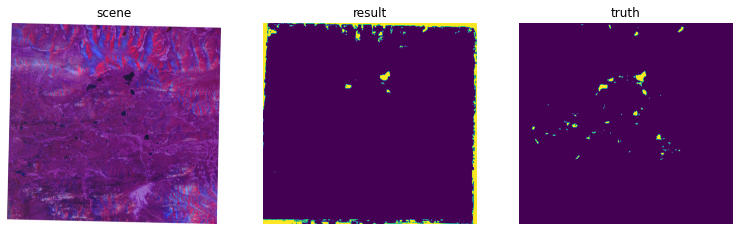

In [12]:
idx = 8     # 0-8
img_list = [scene_[idx], wat_[idx], truth_[idx]]
img_name_list = ['scene', 'result', 'truth']
clip_list = [2,0,0]
plt.figure(figsize=(13, 8))
imsShow(img_list, img_name_list, clip_list, \
                    color_bands_list=None, axis=None, row=None, col=None)


### 2. Comparison among methods (plot smoothed metric for one test)

In [15]:
##### single -> 1: 87.0; scales -> 4: 94.3; gscales -> 9: 95.5. -> 2: 95.4
####################################################################
## 1. Model name and the selected metric
# id_model =  '10'
model_name = ['single/traset/as_des/model_1', \
              'scales/traset/as_des/model_1', \
              'gscales/traset/as_des/model_1']

# metric_name = 'val_miou'
path_metrics_single = config.root_proj + '/model/trained_model/' + model_name[0] + '_metrics.csv'
path_metrics_scales = config.root_proj + '/model/trained_model/' + model_name[1] + '_metrics.csv'
path_metrics_gscales = config.root_proj + '/model/trained_model/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_single = pd.read_csv(path_metrics_single)
metrics_scales = pd.read_csv(path_metrics_scales)
metrics_gscales = pd.read_csv(path_metrics_gscales)
# print(metrics_single.tail(2)); 
# print(metrics_scales.tail(2)); 
print(metrics_gscales.tail(2))



     tra_loss  tra_miou  val_loss  val_miou
298  0.338561  0.919934  0.150628  0.933873
299  0.335692  0.942449  0.150586  0.933948


In [16]:
### metrics smooth
metrics_single_smooth_x, metrics_single_smooth_y = smooth(metrics_single['val_miou'].to_numpy(), num_sam=20)
metrics_scales_smooth_x, metrics_scales_smooth_y = smooth(metrics_scales['val_miou'].to_numpy(), num_sam=20)
metrics_gscales_smooth_x, metrics_gscales_smooth_y = smooth(metrics_gscales['val_miou'].to_numpy(), num_sam=20)



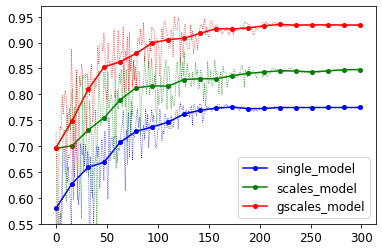

In [17]:
plt.rcParams.update({'font.size': 12})
color = ['blue', 'green', 'red']
plt.plot(metrics_single['val_miou'], color=color[0], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_single_smooth_x, metrics_single_smooth_y, color=color[0], \
            marker='o', markerfacecolor=color[0], markersize=4, linewidth=1.5, label= 'single_model')
plt.plot(metrics_scales['val_miou'], color=color[1], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_scales_smooth_x, metrics_scales_smooth_y, color=color[1], \
            marker='o', markerfacecolor = color[1], markersize=4, linewidth = 1.5,label= 'scales_model')

plt.plot(metrics_gscales['val_miou'], color=color[2], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_gscales_smooth_x, metrics_gscales_smooth_y, color=color[2], \
            marker='o', markerfacecolor=color[2], markersize=4, linewidth = 1.5, label= 'gscales_model')
plt.ylim(top=0.97, bottom=0.55)
plt.legend()


### 3. Comparison among methods (plot metric line with confidence interval)


In [18]:
### metrics path
dir_metric_gscales = config.root_proj + '/model/trained_model/gscales/traset/as_des'
paths_metric_gscales = glob(dir_metric_gscales + '/model_[0-9]_metrics.csv')
dir_metric_scales = config.root_proj + '/model/trained_model/scales/traset/as_des'
paths_metric_scales = glob(dir_metric_scales + '/model_[0-9]_metrics.csv')
dir_metric_single = config.root_proj + '/model/trained_model/single/traset/as_des'
paths_metric_single = glob(dir_metric_single + '/model_[0-9]_metrics.csv')



### Concat metrics obtained by different iteration

In [19]:
metrics_gscales = csv_merge(paths_metric_gscales, i_csv='i_test', i_row='epoch', sam=5)
metrics_scales = csv_merge(paths_metric_scales, i_csv='i_test', i_row='epoch', sam=5)
metrics_single = csv_merge(paths_metric_single, i_csv='i_test', i_row='epoch', sam=5)
metrics_models = csv_merge([metrics_single, metrics_scales, metrics_gscales], i_csv='i_model')

print(metrics_models.head())
print('gscales model: ',metrics_gscales.shape)
print('models:', metrics_models.shape)



   tra_loss  tra_miou  val_loss  val_miou  epoch  i_test  i_model
0  0.532655  0.506015  0.369166  0.606475      1       1        1
1  0.412705  0.639013  0.369490  0.626437      6       1        1
2  0.406678  0.688933  0.323144  0.678866     11       1        1
3  0.408625  0.706401  0.313394  0.682078     16       1        1
4  0.403475  0.679032  0.350634  0.639495     21       1        1
gscales model:  (540, 6)
models: (1620, 7)


In [27]:
### change the column name and the corresponding values
metrics_models_ = metrics_models.rename(columns={'i_model': 'Model'})
metrics_models_['Model'] = metrics_models_['Model'].replace([1], 'Single scale')
metrics_models_['Model'] = metrics_models_['Model'].replace([2], 'Multiple scales')
metrics_models_['Model'] = metrics_models_['Model'].replace([3], 'Gated multiple scales')


### Plot epoch-val_miou figure.

Text(0, 0.5, 'Validation MIoU (%)')

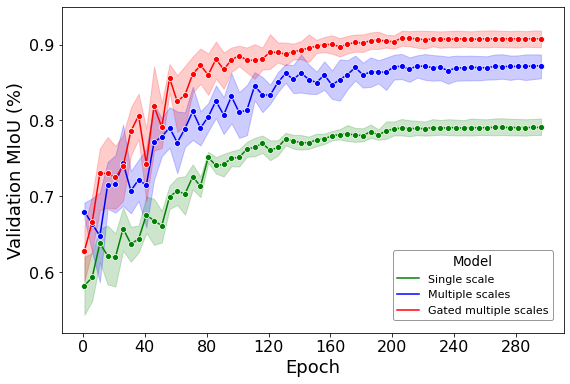

In [28]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(9,6))
ax_1 = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_miou', \
                      hue='Model', palette=colors, marker='o', ci=90, ax=ax_1)

# ax.legend().set_visible(False)
ax_1.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.49, -0.23, 0.5, 0.5))
ax_1.set_ylim(top=0.95, bottom=0.52)
y_major_locator=MultipleLocator(0.10)
ax_1.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(40)
ax_1.xaxis.set_major_locator(x_major_locator)
ax_1.set_xlabel('Epoch', fontsize=18) 
ax_1.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_miou.png', bbox_inches='tight')


Text(0, 0.5, 'Validation MIoU (%)')

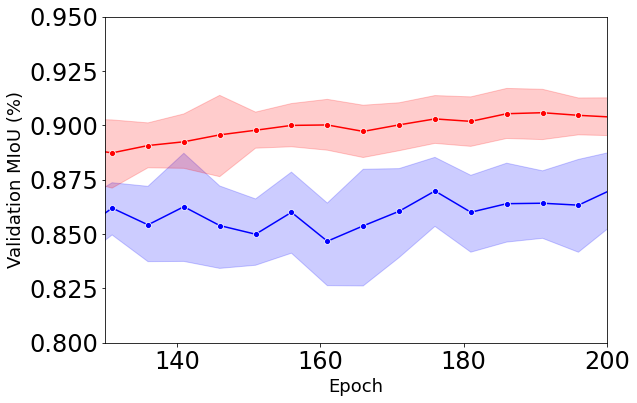

In [29]:
plt.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_miou', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

ax.legend().set_visible(False)
ax.set_ylim(top=0.95, bottom=0.8)
ax.set_xlim(left=130, right=200)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.025)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_miou_l.png', bbox_inches='tight')



### Plot epoch-val_loss figure.

Text(0, 0.5, 'Validation loss')

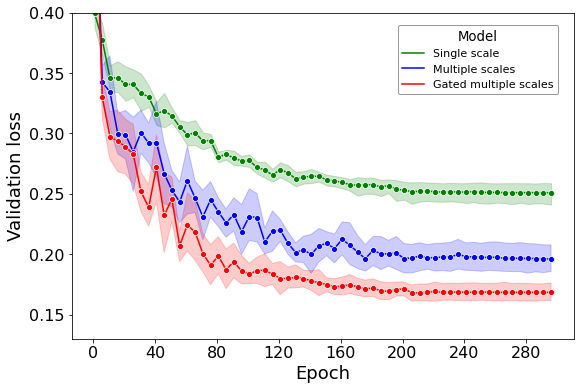

In [30]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_loss', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

# ax.legend().set_visible(False)
ax.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.48, 0.48, 0.5, 0.5))
ax.set_ylim(top=0.4, bottom=0.13)
x_major_locator=MultipleLocator(40)
y_major_locator=MultipleLocator(0.05)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_loss.png', bbox_inches='tight')



Text(0, 0.5, 'Validation loss')

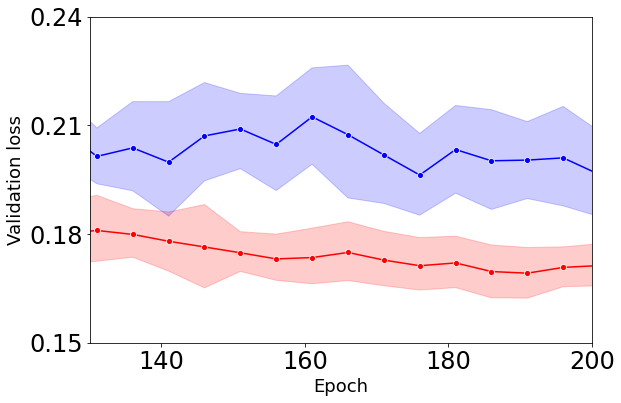

In [31]:
plt.rcParams.update({'font.size': 24})
colors = ['green', 'blue', 'red']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_loss', \
                  hue='Model', palette=colors, marker='o', ci=90, ax=ax)
ax.legend().set_visible(False)
ax.set_xlim(left=130, right=200)
ax.set_ylim(top=0.24, bottom=0.15)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.03)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/methods_compare_loss_l.png', bbox_inches='tight')



### **Visualize the results derived by different methods**

In [32]:
wat_gscales_, wat_scales_, wat_single_ = [], [], []
s1_as_, s2_scene_, truth_ = [], [], []

for idx in config.val_ids: 
    scene_id = 'scene' + str(idx+1).zfill(2)
    path_valsite_wat_single = config.root_proj+'/data/dset/valsite_wat_infer/single/as_des/'+scene_id+'_s1_water.tif'
    path_valsite_wat_scales = config.root_proj+'/data/dset/valsite_wat_infer/scales/as_des/'+scene_id+'_s1_water.tif'
    path_valsite_wat_gscales= config.root_proj+'/data/dset/valsite_wat_infer/gscales/as_des/'+scene_id+'_s1_water.tif'
    path_valsite_as = config.root_proj+'/data/dset/s1_ascend/'+scene_id+'_s1as.tif'
    # path_valsite_des = config.root_proj+'/data/dset/s1_descend/'+scene_id+'_s1des.tif'
    path_valsite_truth = config.root_proj+'/data/dset/s1_truth/'+scene_id+'_wat_truth.tif'
    path_valsite_s2 = config.root_proj+'/data/dset/s2_img/'+scene_id+'_s2.tif'
    #### ----- read in data
    wat_gscales, wat_gscales_info = readTiff(path_valsite_wat_gscales)
    wat_scales, wat_scales_info = readTiff(path_valsite_wat_scales)
    wat_single, wat_single_info = readTiff(path_valsite_wat_single)    
    s1_as, s1_as_info = readTiff(path_valsite_as)
    if idx < 20: 
        s2_scene, s2_scene_info = readTiff(path_valsite_s2)
    truth, truth_info = readTiff(path_valsite_truth)    
    wat_gscales_.append(wat_gscales); wat_scales_.append(wat_scales)
    wat_single_.append(wat_single); s1_as_.append(s1_as)
    s2_scene_.append(s2_scene); truth_.append(truth)
print(len(wat_gscales_))


10


In [33]:
def local_dif(s1_scene, s2_scene, truth, wat_gscales, wat_scales, wat_single, region):
    ### focus on a local region 
    row_start, row_end, col_start, col_end = region
    s1_scene_l = s1_scene[row_start:row_end,col_start:col_end]
    s2_scene_l = s2_scene[row_start:row_end,col_start:col_end]
    truth_l = truth[row_start:row_end,col_start:col_end]
    wat_gscales_l = wat_gscales[row_start:row_end,col_start:col_end]
    wat_scales_l = wat_scales[row_start:row_end,col_start:col_end]
    wat_single_l = wat_single[row_start:row_end,col_start:col_end]
    ### calculate difference
    dif_gscales_l = (truth_l+1)*2 - wat_gscales_l
    dif_scales_l = (truth_l+1)*2 - wat_scales_l
    dif_single_l = (truth_l+1)*2 - wat_single_l
    return s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l


### Small-size water recognition （!!single-scale model supervior to gscale model）

In [ ]:
### global variables
cmap_wat = ListedColormap(["white", "blue"])
cmap_err = ListedColormap(['red', 'black', 'blue','white'])

size: (3292, 3263)


Text(0.5, 1.0, 'single model')

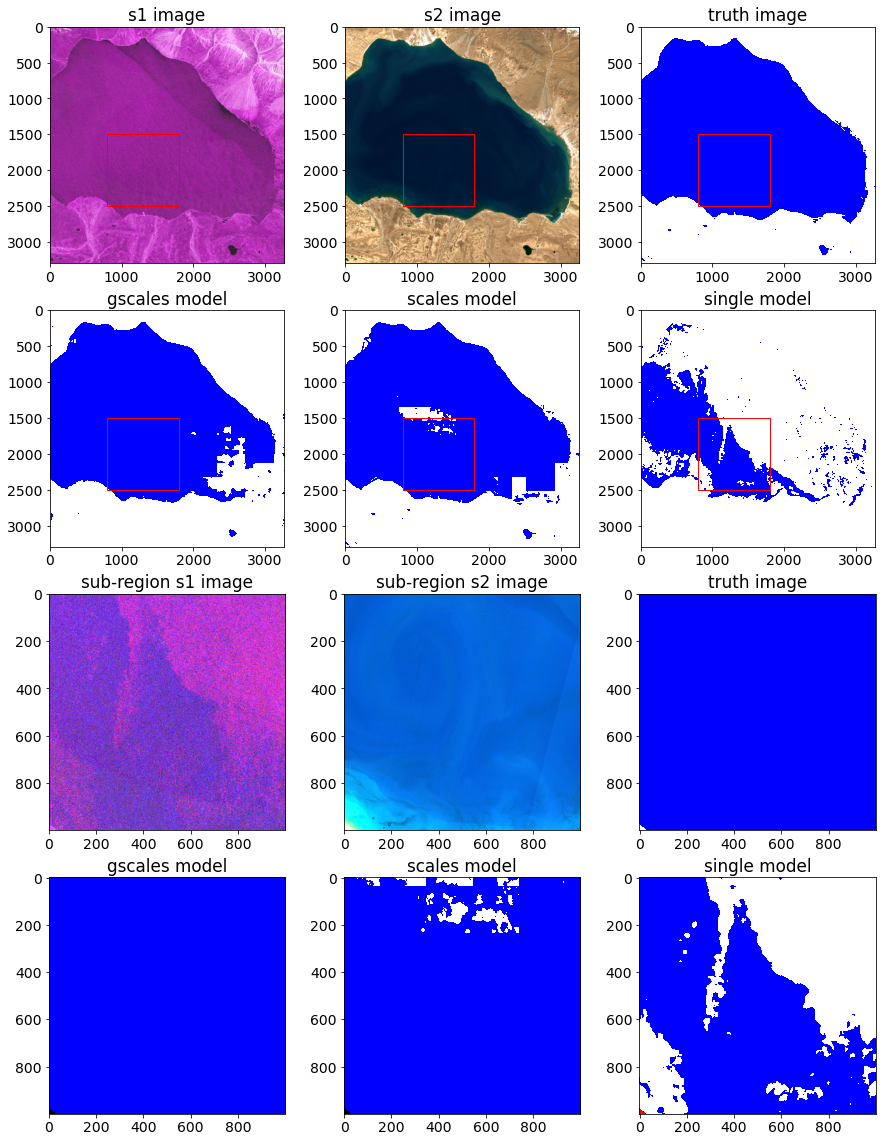

In [79]:
idx = 2  # 
plt.rcParams.update({'font.size': 14})
print('size:', truth_[idx].shape)
sub_region = [1500, 2500, 800, 1800]  ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
                s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)
plt.figure(figsize=(15,20))
### water map for selected scene
plt.subplot(4,3,1); imgShow(s1_as_[idx], color_bands=(0,1,0)); plt.title('s1 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,2); imgShow(s2_scene_[idx]); plt.title('s2 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none') # create Rectangle patch
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(4,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
### error map for the sub-region
plt.subplot(4,3,7); imgShow(s1_scene_l); plt.title('sub-region s1 image')
plt.subplot(4,3,8); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(4,3,9); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(4,3,10); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(4,3,11); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(4,3,12); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')



### Easy water body -> scene1 (✓1)

size: (3076, 3373)


Text(0.5, 1.0, 'single model')

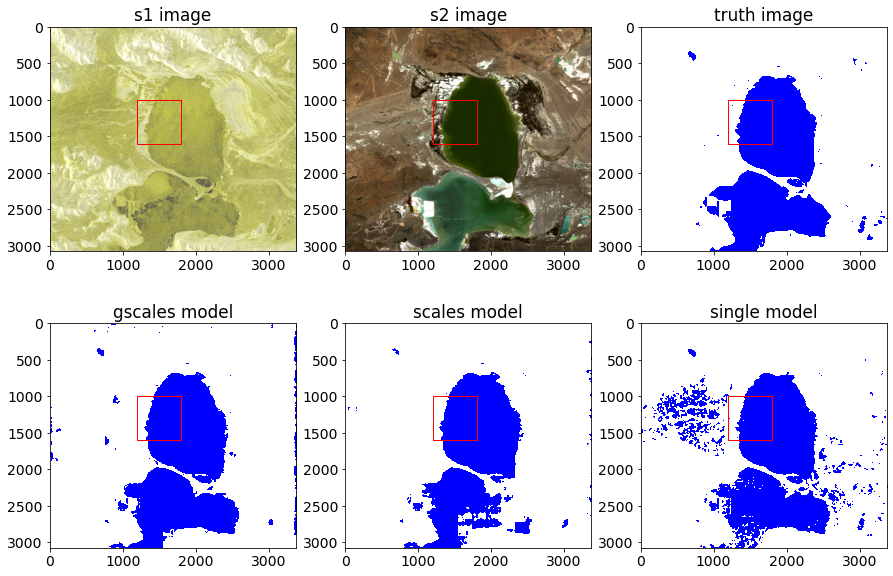

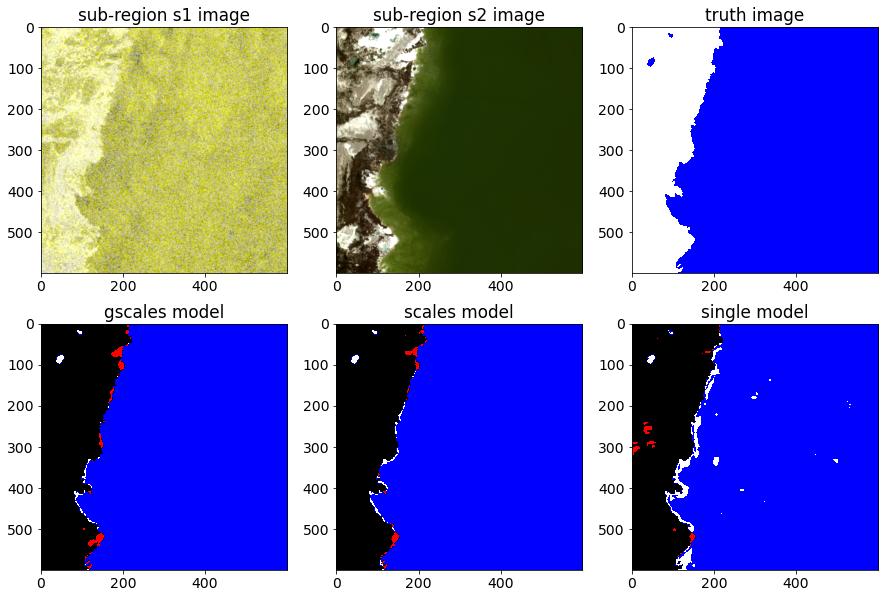

In [86]:
idx = 5
plt.rcParams.update({'font.size': 14})
img_list = [scene_[idx], s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx]]
print('size:', truth_[idx].shape)
sub_region = [1000, 1600, 1200, 1800]  ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
              s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)

plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(scene_[idx], color_bands=(0,0,1)); plt.title('s1 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,2); imgShow(s2_scene_[idx]); plt.title('s2 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
#### show the sub-region image
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(s1_scene_l, color_bands=(0,0,1)); plt.title('sub-region s1 image')
plt.subplot(2,3,2); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')



### Hard water body -> scene2 (✓2)

size: (3509, 3962)


Text(0.5, 1.0, 'single model')

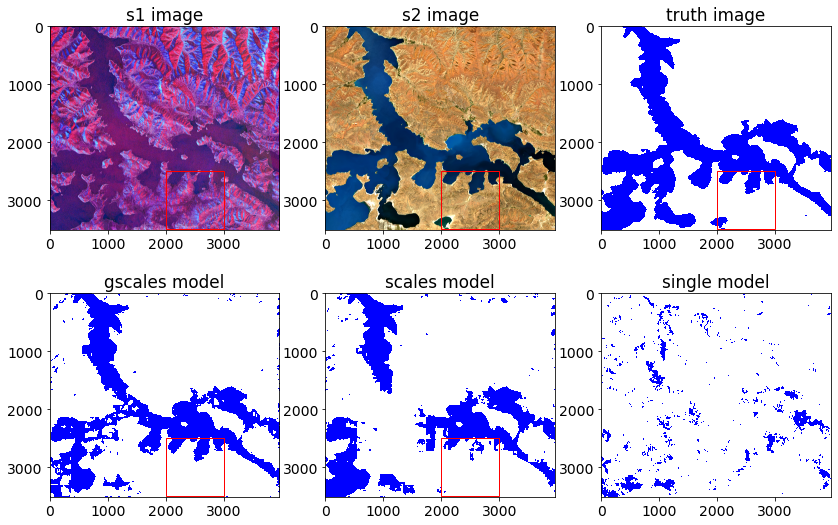

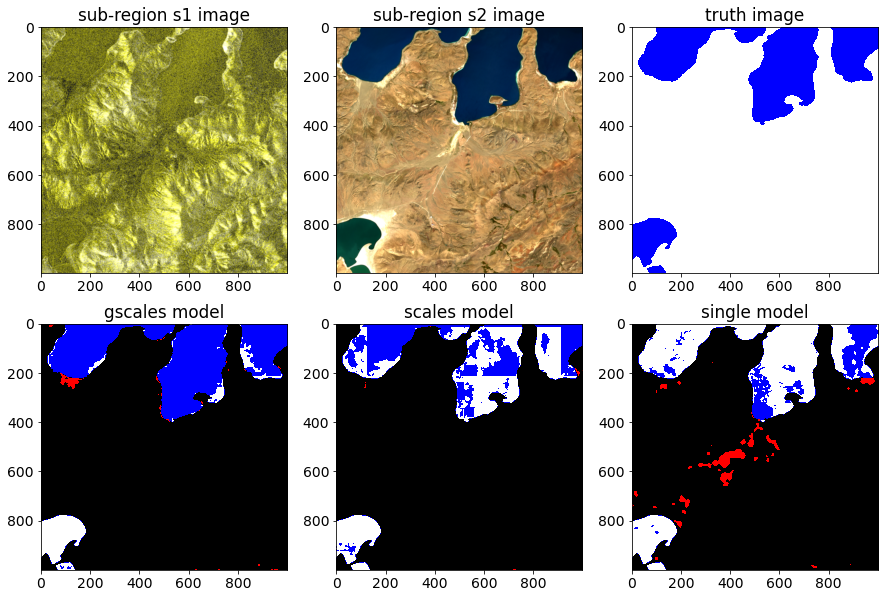

In [88]:
idx = 1
img_list = [scene_[idx], s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx]]
print('size:', truth_[idx].shape)
sub_region = [2500, 3500, 2000, 3000]       ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
                s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(scene_[idx]); plt.title('s1 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,2); imgShow(s2_scene_[idx]); plt.title('s2 image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
#### show the sub-region image
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(s1_scene_l, color_bands=(0,0,1)); plt.title('sub-region s1 image')
plt.subplot(2,3,2); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')



### Large-size water body -> scene6 (✓3)

size: (3076, 3373)


Text(0.5, 1.0, 'single model')

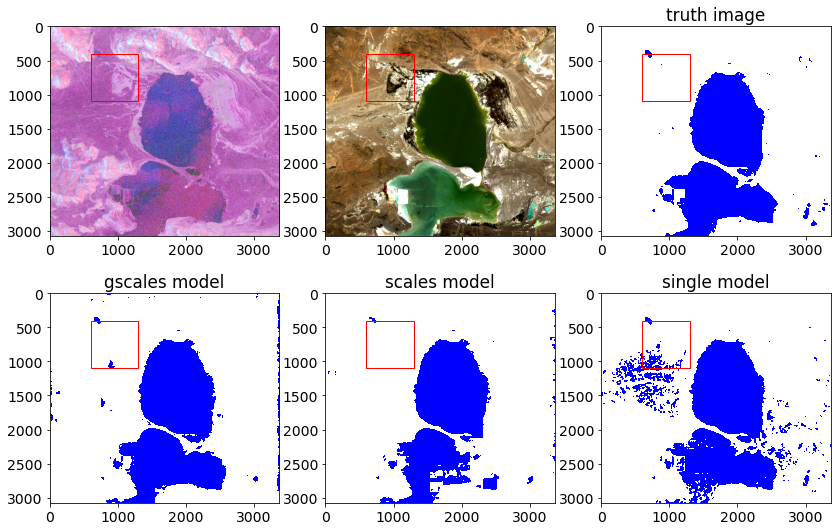

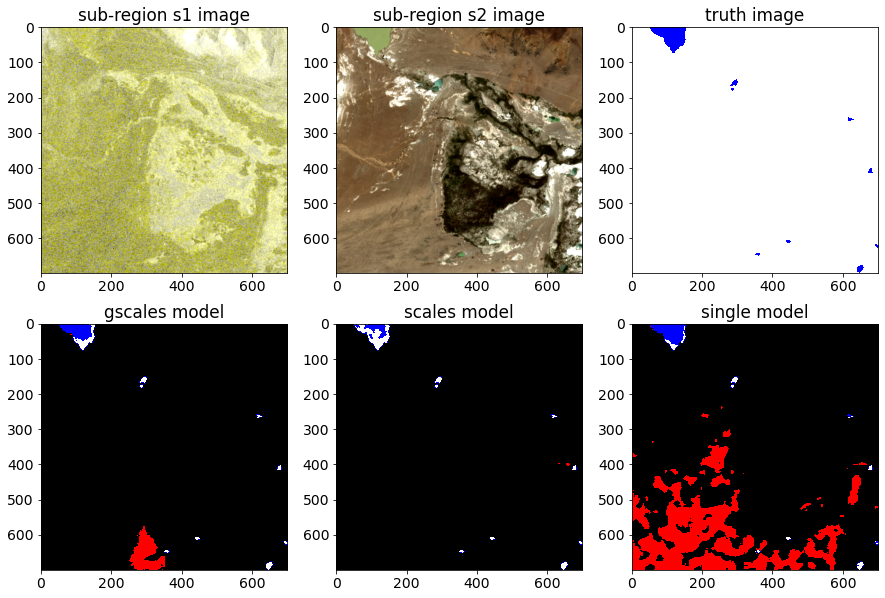

In [92]:
idx = 5
img_list = [scene_[idx], s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx]]
print('size:', truth_[idx].shape)
sub_region = [400, 1100, 600, 1300]     ## row_start, row_end, col_start, col_end
x0, y0, width, height = sub_region[2], sub_region[0], \
                              sub_region[3]-sub_region[2], sub_region[1]-sub_region[0]
s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scene_[idx], \
                s2_scene_[idx], truth_[idx], wat_gscales_[idx], wat_scales_[idx], wat_single_[idx], sub_region)
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(scene_[idx])
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,2); imgShow(s2_scene_[idx], clip_percent=5)
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('truth image')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,4); plt.imshow(wat_gscales_[idx], cmap=cmap_wat); plt.title('gscales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,5); plt.imshow(wat_scales_[idx], cmap=cmap_wat); plt.title('scales model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
plt.subplot(2,3,6); plt.imshow(wat_single_[idx], cmap=cmap_wat); plt.title('single model')
rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca(); ax.add_patch(rect)
#### show the sub-region image
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); imgShow(s1_scene_l, color_bands=(0,0,1)); plt.title('sub-region s1 image')
plt.subplot(2,3,2); imgShow(s2_scene_l); plt.title('sub-region s2 image')
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_err); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_err); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_err); plt.title('single model')

